<a href="https://colab.research.google.com/github/ClemensDiekmann/durban-port/blob/yolov8-obb/yolov8_obb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Train a YOLOv8 Oriented Bounding Boxes Model

---

[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-keypoint-detection-custom-train)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/ultralytics/ultralytics)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics.

In this guide, we will walk through how to train a YOLOv8 oriented bounding box detection model.

If you notice that our notebook behaves incorrectly, let us know by [opening an issue on the Roboflow Notebooks repository](https://github.com/roboflow/notebooks/issues).

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading our [YOLOv8 oriented bounding box training blog post](https://blog.roboflow.com/train-yolov8-obb-model/).

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Checking that our Colab environment has a GPU
- Installing YOLOv8
- Preparing a dataset
- Training a YOLOv8 OBB model
- Running inference on our model

Without further ado, let's get started!

In [24]:
def push_to_github(commit_message):
    !git add .
    !git commit -m "{commit_message}"
    !git push

# Use it like:
#push_to_github("Updated model training parameters")

In [25]:
push_to_github("Model trained first time.")

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Wed Jun 18 13:13:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install YOLOv8

To install YOL0v8, run the following command:

In [3]:
!pip install ultralytics -q

import ultralytics
ultralytics.checks()

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.5/112.6 GB disk)


Now, we can import YOLOv8 into our Notebook:

In [4]:
from ultralytics import YOLO

from IPython.display import display, Image

## Roboflow Universe

Need data for your project? Check out Roboflow Universe, a repository of open source computer vision datasets. You can export any dataset labeled for instance segmentation as a YOLOv8 Oriented Bounding Boxes dataset for use in training a YOLOv8 Oriented Bounding Boxes model.

[![Roboflow Universe](https://media.roboflow.com/notebooks/template/uni-banner-frame.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672878480290)](https://universe.roboflow.com/)



## Prepare a custom dataset

Building a custom dataset can be a painful process. It might take dozens or even hundreds of hours to collect images, label them, and export them in the proper format. Fortunately, Roboflow makes this process as straightforward and fast as possible. Let us show you how!

### Step 1: Creating project

Before you start, you need to create a Roboflow [account](https://app.roboflow.com/login). Once you do that, you can create a new project in the Roboflow [dashboard](https://app.roboflow.com/). Choose "Object Detection" as your project type.

<img src="https://media.roboflow.com/obb-tutorial/create.png" alt="Object detection selected on the Roboflow Create Project pop up" height="300" />

### Step 2: Uploading images

Next, add the data to your newly created project. You can do it via API or through our [web interface](https://docs.roboflow.com/adding-data/object-detection).

If you drag and drop a directory with a dataset in a supported format, the Roboflow dashboard will automatically read the images and annotations together.

<img src="https://media.roboflow.com/obb-tutorial/upload.png" alt="Uploading images to Roboflow" height="300" />

### Step 3: Label Data

If you only have images, you can label them with oriented bounding boxes in [Roboflow Annotate](https://docs.roboflow.com/annotate).

**To label an oriented bounding box, use our polygon annotation tool.**

You can also take an existing segmentation dataset from your workspace or Roboflow Universe and export it as OBB.

<img src="https://media.roboflow.com/obb-tutorial/annotate.png" alt="Annotate an image" height="300" />

### Step 4: Generate new dataset version

Now that we have our images and annotations added, we can Generate a Dataset Version. When Generating a Version, you may elect to add preprocessing and augmentations. This step is completely optional, however, it can allow you to significantly improve the robustness of your model.

<img src="https://media.roboflow.com/keypoint/version.png" alt="Generate a dataset version" height="300" />

### Step 5: Export dataset

Once the dataset version is generated, we can download it for use in training a model.

![Generate a dataset version](https://media.roboflow.com/keypoint/export.png)


In [12]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow --quiet

import roboflow

roboflow.login()

rf = roboflow.Roboflow()
project = rf.workspace("durban-port-congestion-detection-wdiol").project("ship-detection-j5dgs")
version = project.version(1)
dataset = version.download("yolov8-obb")

# ✅ Unzip the downloaded dataset
import zipfile
import os

zip_path = os.path.join(dataset.location, "roboflow.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset.location)

# ✅ Now the data.yaml file should exist
import yaml

with open(f'{dataset.location}/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data['path'] = dataset.location

with open(f'{dataset.location}/data.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)


mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
You are already logged into Roboflow. To make a different login,run roboflow.login(force=True).
loading Roboflow workspace...
loading Roboflow project...


BadZipFile: File is not a zip file

In [13]:
import zipfile
import os

zip_path = os.path.join(dataset.location, "roboflow.zip")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(dataset.location)

# ✅ Now the data.yaml file should exist
import yaml

with open(f'{dataset.location}/data.yaml', 'r') as file:
    data = yaml.safe_load(file)

data['path'] = dataset.location

with open(f'{dataset.location}/data.yaml', 'w') as file:
    yaml.dump(data, file, sort_keys=False)

## Train a YOLOv8 OBB Object Detection Model

With our dataset downloaded, we can now train a YOLOv8 OBB object detection model. Run the code snippet below to start training your model:

In [14]:
from ultralytics import YOLO

model = YOLO('yolov8n-obb.pt')

results = model.train(data=f"{dataset.location}/data.yaml", epochs=100, imgsz=640)

100%|██████████| 6.26M/6.26M [00:00<00:00, 238MB/s]

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)


engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/Ship-Detection-1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-obb.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, project=None, rect=False, resume=False, 

100%|██████████| 755k/755k [00:00<00:00, 100MB/s]

Overriding model.yaml nc=15 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

YOLOv8n-obb summary: 144 layers, 3,083,295 parameters, 3,083,279 gradients, 8.4 GFLOPs

Transferred 391/397 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 299MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 706.9±215.5 MB/s, size: 24.1 KB)


train: Scanning /content/datasets/Ship-Detection-1/train/labels... 46 images, 0 backgrounds, 0 corrupt: 100%|██████████| 46/46 [00:00<00:00, 1616.49it/s]

train: New cache created: /content/datasets/Ship-Detection-1/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.3±0.6 ms, read: 537.4±210.8 MB/s, size: 28.8 KB)


val: Scanning /content/datasets/Ship-Detection-1/valid/labels... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<00:00, 507.72it/s]

val: New cache created: /content/datasets/Ship-Detection-1/valid/labels.cache


Plotting labels to runs/obb/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/obb/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.08G      1.637      3.735      1.499        182        640: 100%|██████████| 3/3 [00:02<00:00,  1.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.18it/s]

                   all         13         92      0.162      0.162       0.19      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       2.4G      1.695      3.729      1.495        234        640: 100%|██████████| 3/3 [00:01<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.98it/s]

                   all         13         92      0.173      0.191      0.214      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.42G      1.503      3.394      1.406        169        640: 100%|██████████| 3/3 [00:02<00:00,  1.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]

                   all         13         92      0.187      0.289      0.271      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.43G      1.215      2.943      1.375        146        640: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.46it/s]

                   all         13         92       0.96      0.249      0.295      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.45G      1.094      2.494      1.368        165        640: 100%|██████████| 3/3 [00:00<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         13         92      0.938      0.301      0.302      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.47G      1.035      1.901       1.25        174        640: 100%|██████████| 3/3 [00:00<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.95it/s]

                   all         13         92      0.955      0.299      0.306      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100       2.5G      1.041      1.668      1.285        177        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]

                   all         13         92      0.958      0.307      0.346      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.51G      0.998      1.439      1.231        148        640: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         13         92      0.958      0.304       0.34      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.53G     0.9393      1.318      1.223        203        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.68it/s]

                   all         13         92      0.967      0.314      0.356      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.55G     0.9352      1.368      1.254        181        640: 100%|██████████| 3/3 [00:01<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]

                   all         13         92      0.967      0.304      0.357      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.57G     0.8972      1.309      1.273        169        640: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         13         92       0.97      0.304      0.373      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.58G     0.9294      1.208      1.205        192        640: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         13         92      0.972      0.299      0.386      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       2.6G      0.918      1.144      1.214        197        640: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         13         92      0.652      0.371      0.397      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.62G     0.8862      1.085       1.14        179        640: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.65it/s]

                   all         13         92      0.691      0.371      0.394      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.64G     0.8697      1.065      1.168        169        640: 100%|██████████| 3/3 [00:00<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.95it/s]

                   all         13         92      0.646      0.419      0.382      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.65G     0.9274      1.098      1.188        182        640: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]

                   all         13         92      0.754      0.431      0.415      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.67G     0.8784      1.022      1.105        183        640: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.29it/s]

                   all         13         92      0.794      0.435      0.436      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.69G     0.8515     0.9973      1.144        153        640: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.58it/s]

                   all         13         92      0.724      0.419      0.417      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.71G     0.8267     0.9559       1.16        150        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]

                   all         13         92      0.776      0.435      0.453      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.73G     0.7836     0.9053      1.124        169        640: 100%|██████████| 3/3 [00:01<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.92it/s]

                   all         13         92      0.789      0.419      0.459      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.74G     0.8125     0.9045      1.124        157        640: 100%|██████████| 3/3 [00:00<00:00,  3.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         13         92      0.373      0.435      0.432      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.76G     0.8429     0.9931      1.092        189        640: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         13         92        0.4      0.419      0.435      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.78G     0.8276     0.9403      1.143        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.11it/s]


                   all         13         92      0.399      0.562      0.455      0.363

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100       2.8G     0.7974     0.8648      1.132        172        640: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.56it/s]

                   all         13         92      0.436      0.609      0.475      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.81G      0.793     0.9036      1.112        170        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         13         92      0.478      0.609      0.514       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.83G     0.8131     0.8842      1.137        171        640: 100%|██████████| 3/3 [00:00<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         13         92      0.724      0.498      0.616      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.85G     0.7579     0.7945      1.086        197        640: 100%|██████████| 3/3 [00:00<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         13         92      0.528      0.641      0.637      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.87G     0.7511     0.8153      1.114        159        640: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]

                   all         13         92      0.549      0.641      0.685      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.88G     0.8202     0.8569      1.122        151        640: 100%|██████████| 3/3 [00:00<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.03it/s]

                   all         13         92      0.549      0.641      0.685      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100       2.9G     0.7652     0.7711      1.089        142        640: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]

                   all         13         92      0.709      0.716      0.763      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.92G     0.7572     0.7921      1.128        145        640: 100%|██████████| 3/3 [00:00<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.68it/s]

                   all         13         92      0.734      0.706      0.759      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.94G     0.7684     0.8394       1.12        184        640: 100%|██████████| 3/3 [00:00<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.65it/s]

                   all         13         92       0.59      0.736      0.715       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.96G     0.8001     0.8165      1.133        183        640: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.79it/s]

                   all         13         92       0.59      0.736      0.715       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.97G     0.7454     0.7491      1.117        172        640: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.90it/s]

                   all         13         92      0.624      0.796      0.743      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.99G     0.7876     0.7831      1.112        194        640: 100%|██████████| 3/3 [00:00<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         13         92      0.651      0.816      0.745      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.01G     0.7589      0.794      1.105        205        640: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.38it/s]

                   all         13         92      0.664      0.816      0.751      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.03G     0.7399     0.6852      1.126        151        640: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.44it/s]

                   all         13         92      0.664      0.816      0.751      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.04G     0.7225     0.7336      1.113        170        640: 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.01it/s]

                   all         13         92      0.713      0.784       0.81       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.06G     0.7165     0.6949      1.098        205        640: 100%|██████████| 3/3 [00:00<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         13         92      0.795      0.738      0.811      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.08G      0.728     0.7256      1.111        162        640: 100%|██████████| 3/3 [00:00<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.83it/s]

                   all         13         92      0.765      0.789      0.814      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100       3.1G     0.7261     0.7166      1.093        177        640: 100%|██████████| 3/3 [00:00<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         13         92      0.765      0.789      0.814      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.12G     0.7336     0.6928        1.1        180        640: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.48it/s]

                   all         13         92      0.742      0.807      0.818      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.13G     0.7816     0.7223       1.08        241        640: 100%|██████████| 3/3 [00:00<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.85it/s]

                   all         13         92      0.745       0.81      0.825      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.15G     0.7128     0.6691      1.094        169        640: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.75it/s]

                   all         13         92      0.924      0.657      0.792      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.17G      0.698     0.6845      1.116        120        640: 100%|██████████| 3/3 [00:00<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.82it/s]

                   all         13         92      0.924      0.657      0.792      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.19G     0.7312     0.6828      1.112        157        640: 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.27it/s]

                   all         13         92      0.935      0.657      0.785      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100       3.2G      0.714     0.6612      1.098        218        640: 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         13         92      0.946      0.657      0.802      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.22G      0.707     0.6398      1.112        185        640: 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


                   all         13         92      0.946      0.653      0.809      0.663

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.24G     0.6947     0.6263      1.078        203        640: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13         92      0.946      0.653      0.809      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.26G     0.6875     0.6168      1.109        189        640: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         13         92      0.802      0.689      0.809      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.27G      0.694     0.6553      1.109        169        640: 100%|██████████| 3/3 [00:00<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         13         92      0.817      0.689      0.802      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.29G     0.6762     0.6163      1.094        159        640: 100%|██████████| 3/3 [00:00<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.71it/s]

                   all         13         92      0.792       0.71      0.766      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.31G     0.6757     0.6402      1.103        150        640: 100%|██████████| 3/3 [00:00<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         13         92      0.792       0.71      0.766      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.33G     0.6901     0.6134      1.052        200        640: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.39it/s]

                   all         13         92       0.81      0.704      0.761      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.34G     0.7273     0.6314       1.09        146        640: 100%|██████████| 3/3 [00:00<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         13         92      0.796       0.72      0.765      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.36G     0.7274     0.6664      1.093        165        640: 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.64it/s]

                   all         13         92      0.783       0.72      0.764      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.38G     0.6818     0.6078      1.061        191        640: 100%|██████████| 3/3 [00:00<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]

                   all         13         92      0.783       0.72      0.764      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100       3.4G     0.6709     0.6378       1.07        157        640: 100%|██████████| 3/3 [00:00<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.49it/s]

                   all         13         92      0.737      0.725      0.767      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.41G      0.636     0.5906      1.097        164        640: 100%|██████████| 3/3 [00:00<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.69it/s]

                   all         13         92        0.7      0.741      0.766      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.43G     0.6903     0.6108      1.137        180        640: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.08it/s]

                   all         13         92      0.698      0.741      0.767      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.45G     0.6931     0.6148       1.07        184        640: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.42it/s]

                   all         13         92      0.698      0.741      0.767      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.47G     0.6377      0.554       1.09        187        640: 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         13         92      0.733      0.733      0.772      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.48G     0.6638     0.6063      1.099        171        640: 100%|██████████| 3/3 [00:00<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         13         92      0.735      0.727      0.771      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100       3.5G     0.6621     0.6091      1.091        177        640: 100%|██████████| 3/3 [00:00<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.45it/s]

                   all         13         92      0.718      0.725      0.776      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.52G      0.644     0.5521      1.101        196        640: 100%|██████████| 3/3 [00:00<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.03it/s]

                   all         13         92      0.718      0.725      0.776      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.54G     0.6095     0.5694      1.076        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         13         92      0.742      0.744      0.807      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.55G      0.591     0.5552      1.074        150        640: 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         13         92      0.751      0.769      0.842      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.57G     0.6588      0.566      1.083        189        640: 100%|██████████| 3/3 [00:00<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         13         92      0.735      0.862      0.844      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.59G     0.6185     0.5366      1.061        147        640: 100%|██████████| 3/3 [00:00<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.38it/s]

                   all         13         92      0.735      0.862      0.844      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.61G     0.6484     0.5583      1.081        188        640: 100%|██████████| 3/3 [00:00<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         13         92      0.757      0.884      0.841      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.62G     0.6797     0.5825      1.076        181        640: 100%|██████████| 3/3 [00:00<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.35it/s]

                   all         13         92       0.73      0.868      0.832      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.64G     0.6127     0.5299      1.076        188        640: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

                   all         13         92      0.723      0.868      0.826      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.66G     0.6071     0.5385       1.09        194        640: 100%|██████████| 3/3 [00:00<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         13         92      0.723      0.868      0.826      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.68G     0.6586     0.5826      1.077        143        640: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

                   all         13         92      0.732      0.856      0.823       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.69G     0.6112     0.5381      1.081        131        640: 100%|██████████| 3/3 [00:00<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         13         92      0.733      0.827      0.821      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.71G     0.6052     0.5262      1.058        195        640: 100%|██████████| 3/3 [00:01<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.15it/s]

                   all         13         92      0.762      0.811      0.824      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.73G     0.6645     0.5504      1.105        185        640: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         13         92      0.762      0.811      0.824      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.75G     0.6265     0.5351      1.087        199        640: 100%|██████████| 3/3 [00:00<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         13         92      0.756      0.814      0.835      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.77G     0.6254     0.5383      1.063        213        640: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.91it/s]

                   all         13         92      0.705      0.868       0.84      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.79G      0.607     0.5355      1.053        221        640: 100%|██████████| 3/3 [00:00<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.36it/s]

                   all         13         92      0.719      0.868      0.847      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       3.8G     0.5971     0.5275      1.114        183        640: 100%|██████████| 3/3 [00:00<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

                   all         13         92      0.719      0.868      0.847      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.82G     0.6043     0.5347      1.121        127        640: 100%|██████████| 3/3 [00:00<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.28it/s]

                   all         13         92      0.719      0.878      0.849      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.84G      0.576     0.5065      1.073        209        640: 100%|██████████| 3/3 [00:00<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.15it/s]

                   all         13         92      0.717      0.866       0.85      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.86G     0.5587     0.5144      1.083        191        640: 100%|██████████| 3/3 [00:00<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.55it/s]

                   all         13         92      0.715       0.86      0.848      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.87G     0.5617     0.5152      1.087        141        640: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         13         92      0.715       0.86      0.848      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.89G     0.5942     0.5217      1.079        147        640: 100%|██████████| 3/3 [00:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.52it/s]

                   all         13         92      0.817      0.773      0.841      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.91G     0.5872      0.498       1.07        177        640: 100%|██████████| 3/3 [00:00<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.84it/s]

                   all         13         92      0.819      0.772      0.842      0.725



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.93G     0.6336     0.5272      1.051        192        640: 100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         13         92      0.709      0.857      0.846      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.94G     0.6043     0.5513      1.115        130        640: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.78it/s]

                   all         13         92      0.709      0.857      0.846      0.726



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.96G     0.5764     0.5047      1.066        149        640: 100%|██████████| 3/3 [00:00<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.61it/s]

                   all         13         92      0.717      0.862      0.849      0.725


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.98G     0.5807     0.5616      1.053        105        640: 100%|██████████| 3/3 [00:01<00:00,  1.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

                   all         13         92      0.772      0.805      0.844      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         4G     0.5856     0.5676      1.088         92        640: 100%|██████████| 3/3 [00:02<00:00,  1.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.29it/s]

                   all         13         92      0.787      0.787      0.845      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      4.02G     0.5342     0.5139      1.071        103        640: 100%|██████████| 3/3 [00:01<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

                   all         13         92      0.787      0.787      0.845      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      4.03G     0.5457     0.5229       1.08        108        640: 100%|██████████| 3/3 [00:00<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.22it/s]

                   all         13         92      0.817      0.793      0.845      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      4.05G     0.5548     0.5216      1.048        103        640: 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.20it/s]

                   all         13         92      0.823      0.793      0.845       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      4.07G     0.5568     0.5118      1.057        107        640: 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.30it/s]

                   all         13         92      0.829      0.791      0.845      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      4.09G     0.5303     0.5023      1.061         92        640: 100%|██████████| 3/3 [00:00<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         13         92      0.829      0.791      0.845      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       4.1G     0.5787     0.5228      1.085         82        640: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.93it/s]

                   all         13         92      0.826       0.79      0.844      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      4.12G     0.5867     0.5164      1.055        100        640: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.77it/s]

                   all         13         92      0.827      0.788      0.844      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      4.14G     0.5704     0.5236      1.052         88        640: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         13         92      0.827      0.788      0.844      0.709



100 epochs completed in 0.042 hours.
Optimizer stripped from runs/obb/train/weights/last.pt, 6.6MB
Optimizer stripped from runs/obb/train/weights/best.pt, 6.6MB

Validating runs/obb/train/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-obb summary (fused): 81 layers, 3,077,999 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.24it/s]


                   all         13         92      0.713      0.856      0.846      0.723
   large_vessel_at_sea          2          3      0.622          1      0.913      0.834
  large_vessel_berthed         13         68      0.882      0.985       0.99      0.881
  small_vessel_berthed         12         21      0.636      0.583      0.636      0.455
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 6.0ms postprocess per image
Results saved to runs/obb/train


Your model will train for 100 epochs. After training, you can run test your model using an image from your test set.

## Test the OBB Object Detection Model

Let's test our OBB detection model on an image:

In [20]:
model = YOLO('runs/obb/train/weights/best.pt')

import os
import random

random_file = random.choice(os.listdir(f"{dataset.location}/test/images"))
file_name = os.path.join(f"{dataset.location}/test/images", random_file)

results = model(file_name)

print(results[0])


image 1/1 /content/datasets/Ship-Detection-1/test/images/P-202201_jpg.rf.d193eb701bf969e6b7154ac61184c685.jpg: 384x640 None11.4ms
Speed: 2.1ms preprocess, 11.4ms inference, 6.1ms postprocess per image at shape (1, 3, 384, 640)
ultralytics.engine.results.Results object with attributes:

boxes: None
keypoints: None
masks: None
names: {0: 'large_vessel_at_sea', 1: 'large_vessel_berthed', 2: 'small_vessel_at_sea', 3: 'small_vessel_berthed'}
obb: ultralytics.engine.results.OBB object
orig_img: array([[[ 55,  62,  65],
        [ 17,  23,  28],
        [ 92,  97, 106],
        ...,
        [137, 141, 142],
        [129, 133, 134],
        [115, 119, 120]],

       [[131, 138, 141],
        [124, 130, 135],
        [ 81,  86,  95],
        ...,
        [137, 141, 142],
        [130, 134, 135],
        [ 98, 102, 103]],

       [[ 73,  81,  81],
        [127, 134, 137],
        [ 77,  83,  90],
        ...,
        [154, 157, 161],
        [157, 160, 164],
        [146, 149, 153]],

       ...

We can visualize our oriented bounding box predictions using the following code:

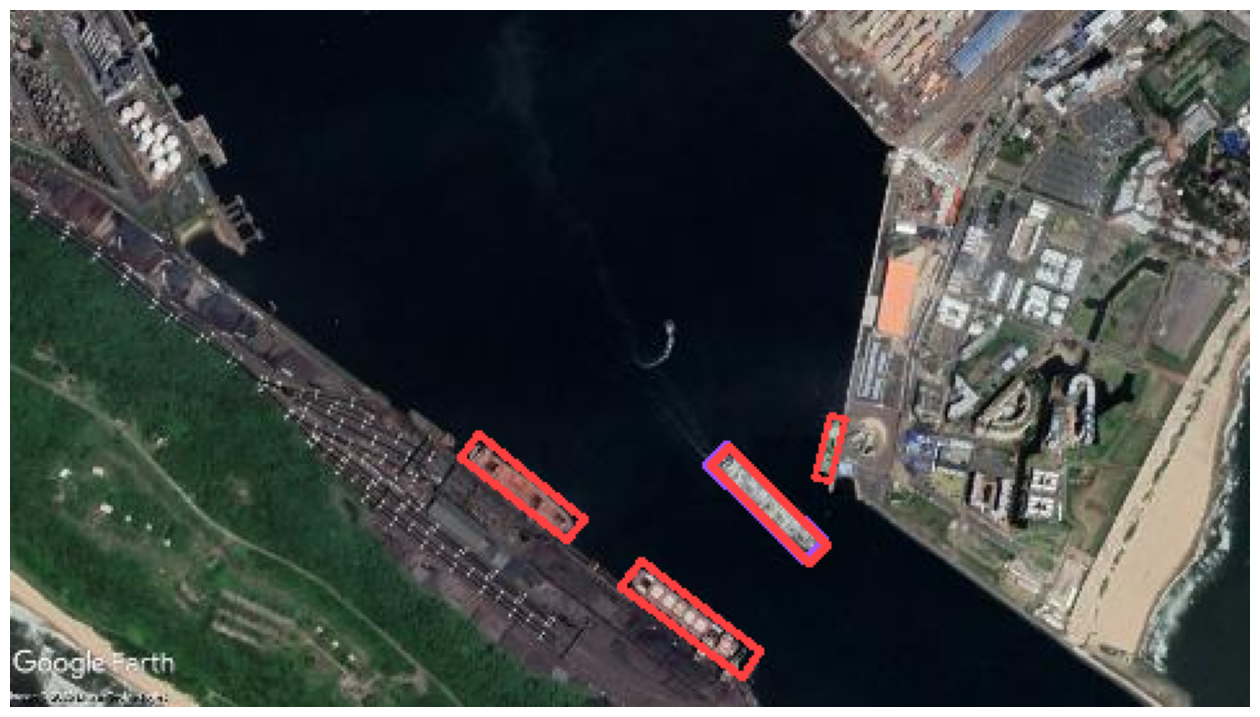

In [23]:
#!pip install supervision -q

import supervision as sv
import cv2

detections = sv.Detections.from_ultralytics(results[0])

oriented_box_annotator = sv.OrientedBoxAnnotator()
annotated_frame = oriented_box_annotator.annotate(
    scene=cv2.imread(file_name),
    detections=detections
)

sv.plot_image(image=annotated_frame, size=(16, 16))

Our model successfully identified the location of solar panels in the image. All solar panels have an oriented bounding box that fit the panel closely.